# 线性回归之波士顿房价预测

本notebook项目流程包括:
1. 数据加载和预处理
2. 数据集划分与多项式特征生成
3. 线性回归模型实现
4. 超参数调优
5. 使用最佳参数训练最终模型
6. 可视化预测结果
7. 预测新数据

In [1]:
# 导入所需库,若未安装可使用pip install进行安装
# 指令示例:
# pip install numpy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 设置图形参数
## 设置中文字体，否则无法在图表中显示中文，若报错则替换为本地的中文字体名称，比如windows上的黑体'SimHei'
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
## 全局设置字体大小
plt.rcParams['font.size'] = 15

## 1. 数据加载和预处理
首先加载波士顿房价数据集,并分割特征和目标变量

In [2]:
# 加载波士顿房价数据集
data = pd.read_csv('TrainingSample/boston.csv')

# 显示数据集基本信息
print("数据集基本信息：\r\n")
print(data.info())

# 分割特征(X)和目标变量(y)
X = data.drop('MEDV', axis=1).values  # MEDV是房价中位数
y = data['MEDV'].values
print("\r\n特征数量: ", X.shape[1])

数据集基本信息：

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB
None

特征数量:  13


## 2. 数据集划分与多项式特征生成
### 2.1 训练集测试集分割函数

In [3]:
def train_test_split(X, y, test_size=0.2, random_state=None):
    """自定义训练集测试集分割函数

    参数:
        X: 特征矩阵
        y: 目标变量
        test_size: 测试集比例
        random_state: 随机种子
    """
    if random_state is not None:
        np.random.seed(random_state)

    n_samples = X.shape[0]
    n_test = int(n_samples * test_size)

    # 随机打乱索引
    indices = np.random.permutation(n_samples)
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]

    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

# 使用函数分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 输出分割后的各数据集大小
print(f"训练集大小: {X_train.shape[0]}")
print(f"测试集大小: {X_test.shape[0]}")

训练集大小: 405
测试集大小: 101


### 2.2 标准化处理类
定义一个标准化类,用于对数据进行标准化处理，即将数据按特征进行中心化和缩放，使得每个特征的均值为0，方差为1。

In [4]:
class StandardScaler:
    """自定义标准化类,实现特征标准化处理"""
    def __init__(self):
        self.mean_ = None  # 均值
        self.scale_ = None # 标准差

    def fit(self, X):
        """计算训练数据的均值和标准差"""
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)

    def transform(self, X):
        """使用已计算的均值和标准差进行标准化"""
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X):
        """先拟合再转换"""
        self.fit(X)
        return self.transform(X)

# 对训练集和测试集进行标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 2.3 多项式特征生成
定义一个函数,用于生成多项式特征,即将原始特征进行组合,生成新的特征。

举个具体例子：

假设原始特征是[x₁,x₂]，degree=2：

1次项：x₁, x₂

2次项：x₁², x₁x₂, x₂²

最终特征矩阵包含5个特征：[x₁, x₂, x₁², x₁x₂, x₂²]

In [5]:
from itertools import product

def combinations_with_replacement(iterable, r):
    """生成带重复的组合"""
    pool = tuple(iterable)
    n = len(pool)
    for indices in product(range(n), repeat=r):
        if sorted(indices) == list(indices):
            yield tuple(pool[i] for i in indices)

def generate_polynomial_features(X, degree):
    """生成多项式特征

    参数:
        X: 原始特征矩阵
        degree: 多项式最高次数
    """
    n_samples, n_features = X.shape
    # 计算输出特征数
    n_output_features = sum([n_features ** i for i in range(1, degree + 1)])
    X_poly = np.zeros((n_samples, n_output_features))

    col_index = 0
    for d in range(1, degree + 1):
        for indices in combinations_with_replacement(range(n_features), d):
            X_poly[:, col_index] = np.prod(X[:, indices], axis=1)
            col_index += 1

    return X_poly

## 3. 线性回归模型实现
实现一个自定义线性回归模型,使用梯度下降优化。

表达式为：y = w₁x₁ + w₂x₂ + ... + wₙxₙ + b = Xw + b

n为特征数, w为权重, b为偏置。

In [6]:
class LinearRegression:
    """自定义线性回归模型,使用梯度下降优化"""
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate  # 学习率
        self.n_iterations = n_iterations    # 迭代次数
        self.weights = None                 # 权重
        self.bias = None                    # 偏置

    def fit(self, X, y):
        """训练模型"""
        n_samples, n_features = X.shape # 样本数, 特征数
        self.weights = np.zeros(n_features) # 初始化权重, 每一个特征对应一个权重
        self.bias = 0

        losses = []

        for _ in range(self.n_iterations):
            # 预测，公式为 y = w₁x₁ + w₂x₂ + ... + wₙxₙ + b = Xw + b
            y_pred = np.dot(X, self.weights) + self.bias

            # 计算梯度，公式为 dw = (1/n) * X.T(y_pred - y), db = (1/n) * Σ(y_pred - y)，即均方误差的导数
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)

            # 执行梯度下降更新参数，公式为 w = w - α * dw, b = b - α * db，α为学习率
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            if y_pred[-1] - y[-1] > 1e+8:
                #梯度爆炸，提前终止
                loss = float('inf')
                losses.append(loss)
                break
            # 记录损失，均方误差MSE
            loss = np.mean((y_pred - y) ** 2)
            losses.append(loss)

        return losses

    def predict(self, X):
        """预测，计算 y_pred = Xw + b"""
        return np.dot(X, self.weights) + self.bias

def mean_squared_error(y_true, y_pred):
    """计算均方误差，MSE = Σ(y_true - y_pred)² / n"""
    return np.mean((y_true - y_pred) ** 2)

## 4. 超参数调优

In [7]:
# 定义超参数搜索空间
learning_rates = [5e-4, 1e-3, 5e-3, 1e-2, 3e-2]
iterations = [10000, 11000, 12000, 13000]
degrees = [1, 2, 3]  # 多项式次数

results = []

# 网格搜索
for degree in degrees:
    print(f"多项式次数: {degree}")
    # 原始特征维度
    n_features = X_train_scaled.shape[1]
    print(f"原始特征维度: {n_features}")
    # 生成多项式特征
    X_train_poly = generate_polynomial_features(X_train_scaled, degree)
    X_test_poly = generate_polynomial_features(X_test_scaled, degree)
    print(f"多项式特征维度: {X_train_poly.shape[1]}")
    for lr in learning_rates:
        for n_iter in iterations:
            # 训练模型
            model = LinearRegression(learning_rate=lr, n_iterations=n_iter)
            train_losses = model.fit(X_train_poly, y_train)

            # 评估模型
            y_train_pred = model.predict(X_train_poly)
            y_test_pred = model.predict(X_test_poly)

            train_mse = mean_squared_error(y_train, y_train_pred)
            test_mse = mean_squared_error(y_test, y_test_pred)
            if test_mse > 1e+8:
                print(f"多项式次数: {degree}, 学习率: {lr}, 迭代次数: {n_iter}, 训练集MSE: 爆炸, 测试集MSE: 爆炸")
                break
            else:
                print(f"多项式次数: {degree}, 学习率: {lr}, 迭代次数: {n_iter}, 训练集MSE: {train_mse:.4f}, 测试集MSE: {test_mse:.4f}")
            results.append((degree, lr, n_iter, train_mse, test_mse))

# 找到最佳超参数
best_result = min(results, key=lambda x: x[4])
print(f"最佳超参数: 多项式次数 = {best_result[0]}, 学习率 = {best_result[1]}, 迭代次数 = {best_result[2]}")
print(f"最佳测试集MSE: {best_result[4]:.2f}")

多项式次数: 1
原始特征维度: 13
多项式特征维度: 13
多项式次数: 1, 学习率: 0.0005, 迭代次数: 10000, 训练集MSE: 22.2742, 测试集MSE: 26.5094
多项式次数: 1, 学习率: 0.0005, 迭代次数: 11000, 训练集MSE: 22.1856, 测试集MSE: 26.3311
多项式次数: 1, 学习率: 0.0005, 迭代次数: 12000, 训练集MSE: 22.1172, 测试集MSE: 26.1850
多项式次数: 1, 学习率: 0.0005, 迭代次数: 13000, 训练集MSE: 22.0611, 测试集MSE: 26.0590
多项式次数: 1, 学习率: 0.001, 迭代次数: 10000, 训练集MSE: 21.8326, 测试集MSE: 25.4570
多项式次数: 1, 学习率: 0.001, 迭代次数: 11000, 训练集MSE: 21.7963, 测试集MSE: 25.3407
多项式次数: 1, 学习率: 0.001, 迭代次数: 12000, 训练集MSE: 21.7673, 测试集MSE: 25.2409
多项式次数: 1, 学习率: 0.001, 迭代次数: 13000, 训练集MSE: 21.7437, 测试集MSE: 25.1548
多项式次数: 1, 学习率: 0.005, 迭代次数: 10000, 训练集MSE: 21.6119, 测试集MSE: 24.4417
多项式次数: 1, 学习率: 0.005, 迭代次数: 11000, 训练集MSE: 21.6115, 测试集MSE: 24.4292
多项式次数: 1, 学习率: 0.005, 迭代次数: 12000, 训练集MSE: 21.6112, 测试集MSE: 24.4202
多项式次数: 1, 学习率: 0.005, 迭代次数: 13000, 训练集MSE: 21.6111, 测试集MSE: 24.4138
多项式次数: 1, 学习率: 0.01, 迭代次数: 10000, 训练集MSE: 21.6109, 测试集MSE: 24.3986
多项式次数: 1, 学习率: 0.01, 迭代次数: 11000, 训练集MSE: 21.6109, 测试集MSE: 24.3978
多项式次数: 1, 学习率:

## 5. 使用最佳参数训练最终模型

最佳参数: 多项式次数 = 2, 学习率 = 0.01, 迭代次数 = 12000


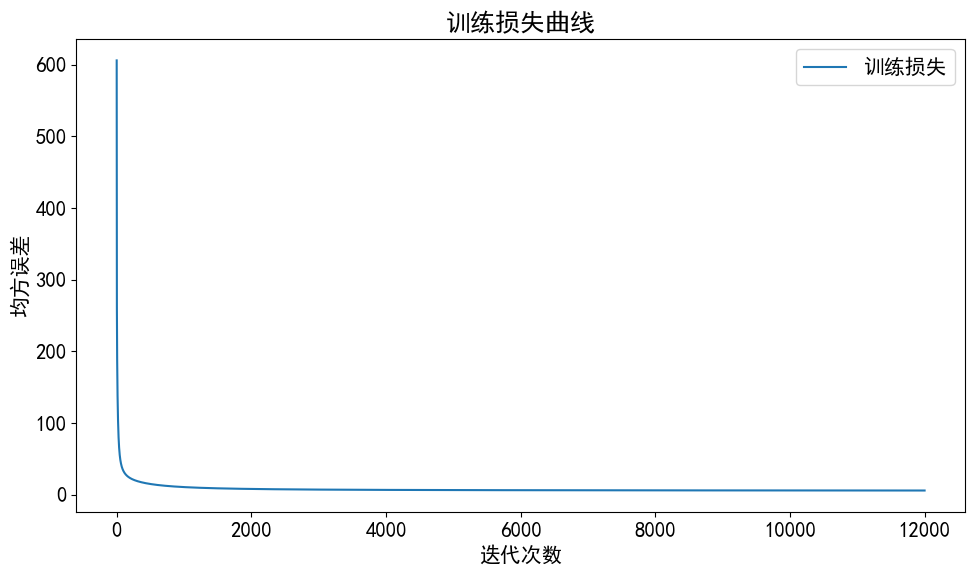

最终模型 - 训练集MSE: 5.67
最终模型 - 测试集MSE: 13.40


In [8]:
# 获取最佳参数
best_degree, best_lr, best_n_iter, _, _ = best_result
print(f"最佳参数: 多项式次数 = {best_degree}, 学习率 = {best_lr}, 迭代次数 = {best_n_iter}")

# 使用最佳参数生成特征
X_train_poly_best = generate_polynomial_features(X_train_scaled, best_degree)
X_test_poly_best = generate_polynomial_features(X_test_scaled, best_degree)

# 训练最终模型
final_model = LinearRegression(learning_rate=best_lr, n_iterations=best_n_iter)
losses = final_model.fit(X_train_poly_best, y_train)

# 绘制损失函数
plt.figure(figsize=(10, 6))
plt.plot(range(best_n_iter), losses, label='训练损失')
plt.xlabel('迭代次数')
plt.ylabel('均方误差')
plt.title('训练损失曲线')
plt.legend()
plt.tight_layout()
plt.show()

# 评估最终模型
y_train_pred = final_model.predict(X_train_poly_best)
y_test_pred = final_model.predict(X_test_poly_best)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"最终模型 - 训练集MSE: {train_mse:.2f}")
print(f"最终模型 - 测试集MSE: {test_mse:.2f}")

## 6. 可视化预测结果
### 6.1 回归线图
如果散点图中的点大致分布在回归线（理想情况下，实际值等于预测值的线）附近，说明模型的预测效果较好。

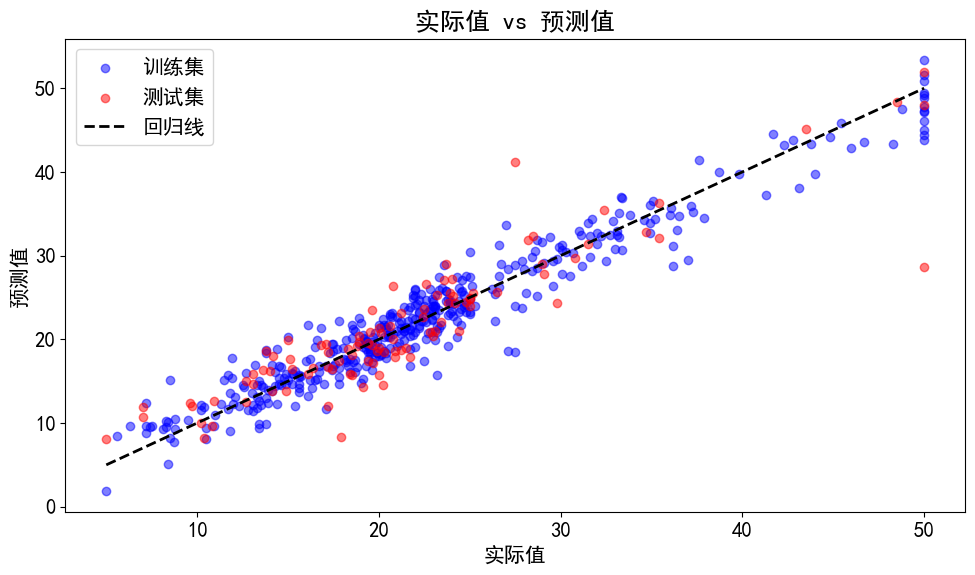

In [9]:
# 回归线图
plt.figure(figsize=(10, 6))

# 绘制训练集的实际值与预测值
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5, label='训练集')
# 绘制测试集的实际值与预测值
plt.scatter(y_test, y_test_pred, color='red', alpha=0.5, label='测试集')

# 绘制回归线
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label='回归线')

plt.xlabel('实际值')
plt.ylabel('预测值')
plt.title('实际值 vs 预测值')
plt.legend()
plt.tight_layout()
plt.show()

### 6.2 残差图
展示预测值与实际值之间的差异（残差），可以帮助了解模型的偏差和方差。

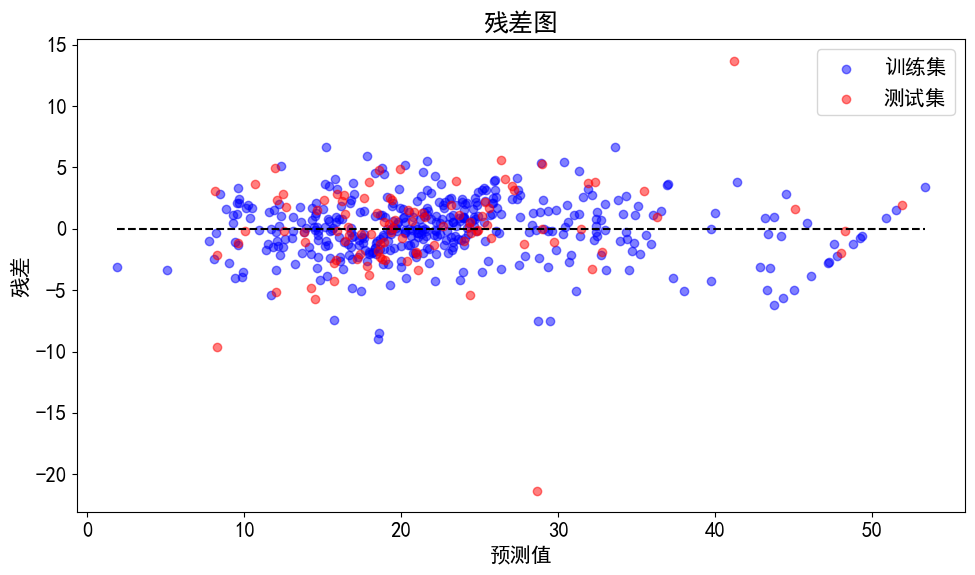

In [10]:
# 残差图
plt.figure(figsize=(10, 6))
plt.scatter(y_train_pred, y_train_pred - y_train, color='blue', alpha=0.5, label='训练集')
plt.scatter(y_test_pred, y_test_pred - y_test, color='red', alpha=0.5, label='测试集')
plt.hlines(y=0, xmin=min(y_train_pred.min(), y_test_pred.min()), xmax=max(y_train_pred.max(), y_test_pred.max()), colors='black', linestyles='dashed')
plt.xlabel('预测值')
plt.ylabel('残差')
plt.title('残差图')
plt.legend()
plt.tight_layout()
plt.show()

### 6.3  特征重要性分析
评估每个特征对模型预测结果的影响程度。在线性回归模型中，特征的重要性可以通过其对应的权重绝对值来衡量。权重的绝对值越大，表示该特征对预测结果的影响越大。

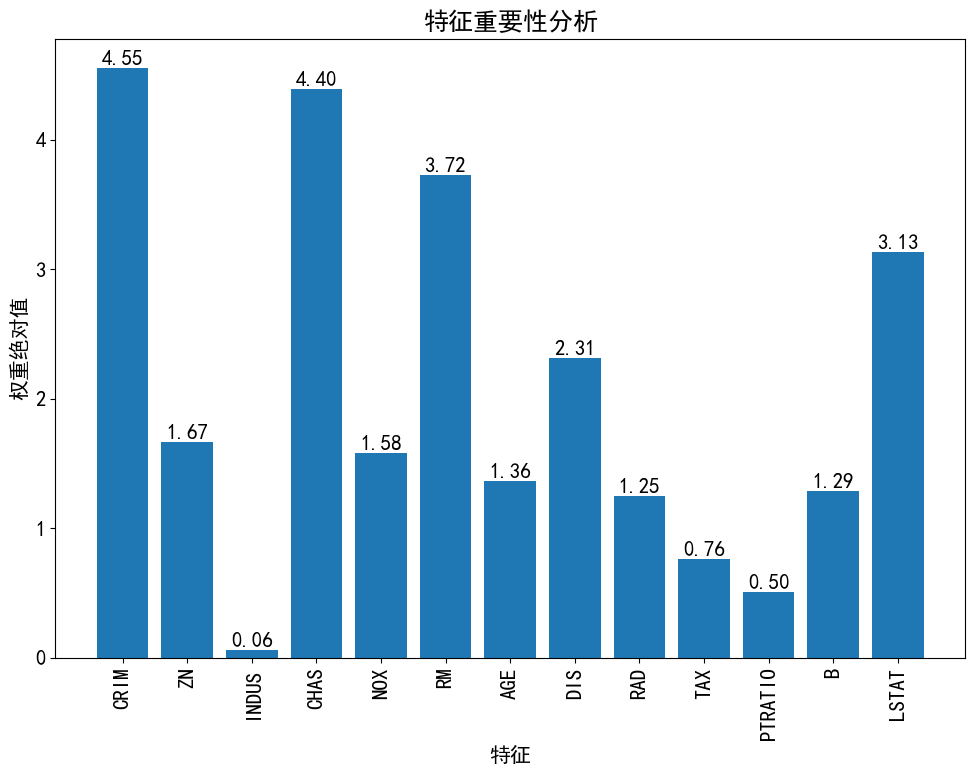

In [11]:
# 分析原始特征的重要性
feature_importance = np.abs(final_model.weights[:X.shape[1]])
feature_names = data.drop('MEDV', axis=1).columns

# 可视化特征重要性
plt.figure(figsize=(10, 8))
bars = plt.bar(feature_names, feature_importance)
plt.title('特征重要性分析')
plt.xlabel('特征')
plt.ylabel('权重绝对值')
plt.xticks(rotation=90)
plt.tight_layout()

# 显示数值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

plt.show()

## 7. 预测新数据

In [12]:
# 创建示例新数据
new_data = np.array([
    [0.02731, 0.0, 7.07, 0, 0.469, 6.421, 78.9, 4.9671, 2, 242, 17.8, 396.90, 9.14],
    [0.03237, 0.0, 2.18, 0, 0.458, 6.998, 45.8, 6.0622, 3, 222, 18.7, 394.63, 2.94]
])

# 标准化新数据
new_data_scaled = scaler.transform(new_data)

# 生成多项式特征
new_data_poly = generate_polynomial_features(new_data_scaled, best_degree)

# 预测
new_predictions = final_model.predict(new_data_poly)

print("新数据的预测结果:")
for i, pred in enumerate(new_predictions):
    print(f"房屋 {i+1} 房价: ${pred:.2f}k")

新数据的预测结果:
房屋 1 房价: $23.51k
房屋 2 房价: $30.69k
